# CAM

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
from PIL import Image

import tensorflow_datasets as tfds
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import copy
import pickle

## CAM을 위한 모델 학습.

In [ ]:
# 데이터 불러오기
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

In [ ]:
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img,
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    '''
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    '''
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [ ]:
num_classes = ds_info.features["label"].num_classes
cam_model = keras.applications.resnet50.ResNet50(
    include_top=False,    # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg',      # GAP를 적용
)
x = cam_model.output
preds = keras.layers.Dense(num_classes, activation='softmax')(x)
cam_model = keras.Model(inputs=cam_model.input, outputs=preds)

In [ ]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
# 데이터셋에 전처리와 배치처리를 적용합니다.
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_val_norm = apply_normalize_on_dataset(ds_test)

In [ ]:
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=10,
    validation_data=ds_val_norm,
    verbose=1,
    use_multiprocessing=True,
)

cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model1.h5'
cam_model.save(cam_model_path)

# history 저장
cam_history_path = os.getenv('HOME')+'/aiffel/class_activation_map/history_cam_model'
with open(cam_history_path, 'wb') as file_pi:
      pickle.dump(history_cam_model.history, file_pi)

Epoch 1/10
750/750 [==============================] - 164s 208ms/step - loss: 2.2730 - accuracy: 0.4346 - val_loss: 3.4133 - val_accuracy: 0.1943
Epoch 2/10
750/750 [==============================] - 155s 206ms/step - loss: 0.6483 - accuracy: 0.8290 - val_loss: 1.4176 - val_accuracy: 0.5924
Epoch 3/10
750/750 [==============================] - 155s 207ms/step - loss: 0.1763 - accuracy: 0.9726 - val_loss: 1.0686 - val_accuracy: 0.6919
Epoch 4/10
750/750 [==============================] - 169s 226ms/step - loss: 0.0558 - accuracy: 0.9975 - val_loss: 1.0076 - val_accuracy: 0.7133
Epoch 5/10
750/750 [==============================] - 155s 207ms/step - loss: 0.0297 - accuracy: 0.9990 - val_loss: 0.9840 - val_accuracy: 0.7271
Epoch 6/10
750/750 [==============================] - 155s 206ms/step - loss: 0.0191 - accuracy: 0.9995 - val_loss: 1.0001 - val_accuracy: 0.7271
Epoch 7/10
750/750 [==============================] - 155s 207ms/step - loss: 0.0148 - accuracy: 0.9997 - val_loss: 0.9888 -

/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [ ]:
# # 모델 불러오기
# cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model1.h5'
# cam_model = tf.keras.models.load_model(cam_model_path)
# # 히스토리 불러오기
# cam_history_path = os.getenv('HOME')+'/aiffel/class_activation_map/history_cam_model'
# with open('cam_history_path, "rb") as file_pi:
#     history_cam_model = pickle.load(file_pi)

# # 학습된 모델.
# cam_model_path = os.getenv('HOME')+'/data/cam_model.h5'
# cam_model = tf.keras.models.load_model(cam_model_path)

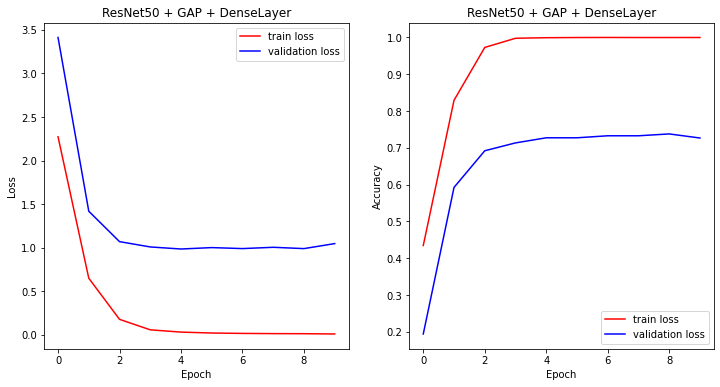

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(history_cam_model.history['loss'], 'r')
ax1.plot(history_cam_model.history['val_loss'], 'b')
ax1.set_title('ResNet50 + GAP + DenseLayer')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.legend(['train loss', 'validation loss'], loc='upper right')

ax2.plot(history_cam_model.history['accuracy'], 'r')
ax2.plot(history_cam_model.history['val_accuracy'], 'b')
ax2.set_title('ResNet50 + GAP + DenseLayer')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Epoch')
ax2.legend(['train loss', 'validation loss'], loc='lower right')

plt.show()

## CAM 구현하기
### 1. 이번 노드에 나왔던 CAM을 직접 구현해 봅시다. 예제 코드를 최대한 보지 말고, 설명과 이론을 보고 구현해 보세요.

In [ ]:
def generate_cam(model, item):
    cam_image = None
    item = copy.deepcopy(item) # 받은 데이터를 깊은 복사
    # 만든 map을 원본 크기로 만들기 위해 저장
    width = item['image'].shape[1]
    height = item['image'].shape[0]

    # 이미지를 모델에 넣고 특징맵을 추출하기 위해 전처리.
    img_tensor, class_idx = normalize_and_resize_img(item)

    # (1) 특성 맵, cam을 을 얻을 모델을 새로 정의
    cam_model = tf.keras.models.Model([model.inputs],
                                      [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    conv_outputs = conv_outputs[0, :, :, :]

    # (2) 클래스별 확률을 얻기 위한 소프트맥스 레이어의 가중치
    class_weights = model.layers[-1].get_weights()[0]

    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image)
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height))

    return cam_image

### 2. 만든 함수로 CAM 이미지를 생성합시다.

In [ ]:
def get_one(ds):
    ds.shuffle(200)
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

40


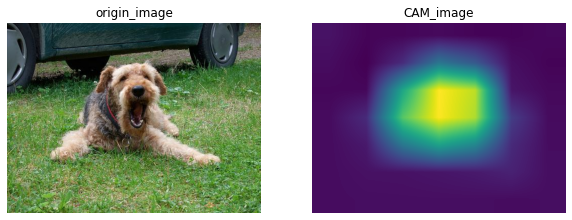

In [ ]:
item = get_one(ds_test)
print(item['label'])

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
cam_image = generate_cam(cam_model, item)

ax[0].imshow(item['image'])
ax[0].set_title('origin_image')
ax[0].axis("off")
ax[1].imshow(cam_image)
ax[1].set_title('CAM_image')
ax[1].axis("off")

plt.show()

### 3. 원본 이미지와 CAM 이미지를 입력으로 받고 두 개의 이미지의 투명도를 조정, 하나의 이미지에서 원본과 CAM을 겹쳐 보여주는 `visualize_cam_on_image()` 함수를 만들어보세요.

In [ ]:
def visualize_cam_on_image(cam_image, image, a=0.5):
    return  cv2.addWeighted(cam_image, a, image, (1.0-a), 0.0)

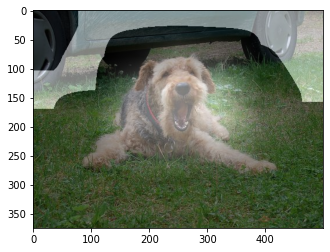

In [ ]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)

# Grad-CAM 구현하기

### 1. 이번 노드에 나왔던 Grad-CAM을 직접 구현해 봅시다. 예제 코드를 최대한 보지 말고, 설명과 이론을 보고 구현해 보세요.

In [ ]:
def generate_grad_cam(model, activation_layer, item):
    grad_cam_image = None
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)

    # 원하는 레이어를 선택할 수 있는 `activation_layer` 추가.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])

    # `GradientTape`를 이용하여 모델의 그레이언트 얻기
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))

        loss = pred[:, class_idx]
        output = conv_output[0]
        grad_val = tape.gradient(loss, conv_output)[0]

    # 위에서 구한 그레이언트를 GAP으로 가중치 구하기
    weights = np.mean(grad_val, axis=(0, 1))

    # 가중치를 conv_output에 곱하고 모두 더한다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        grad_cam_image += w * output[:, :, k]

    # Relu, 0이하 값을 0으로
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    # 이미지 값에서 가장 큰값으로 나눠줌으로 정규화.
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    # 원래 이미지의 크기로 리사이즈
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))

    return grad_cam_image


### 2. 만든 함수로 여러 레이어의 CAM 이미지를 뽑아서 직접 확인해 보세요.

In [ ]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
def cam_plots(cam_model,activation_names,item):

    plt.figure(figsize=(20,5))

    ax = plt.subplot(1,len(activation_names)+1, 1)
    ax.imshow(item['image'])
    plt.title('input image')
    plt.axis("off")
    i = 2
    for act_name in activation_names:
        grad_cam_image = generate_grad_cam(cam_model, act_name, item)
        ax = plt.subplot(1,len(activation_names)+1, i)
        ax.imshow(grad_cam_image)
        plt.title(act_name)
        plt.axis("off")
        i += 1

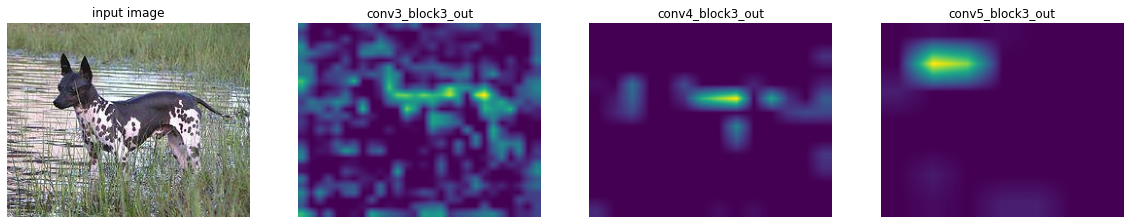

In [ ]:
activation_names = ['conv3_block3_out','conv4_block3_out','conv5_block3_out']
cam_plots(cam_model,activation_names,get_one(ds_test))

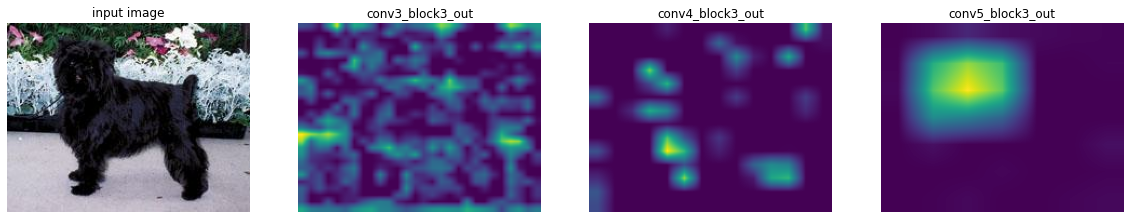

In [ ]:
cam_plots(cam_model,activation_names,get_one(ds_test))

### 3. 위에서 만든 이미지 `visualize_cam_on_image()`함수로 이미지를 시각화해 보세요.

(-0.5, 499.5, 332.5, -0.5)

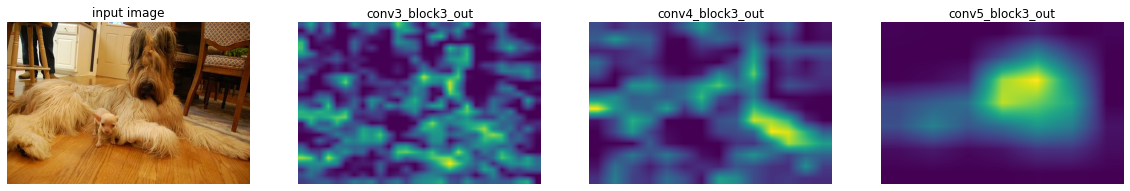

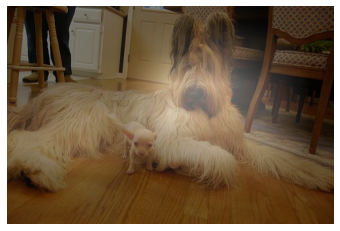

In [ ]:
item = get_one(ds_test)
cam_plots(cam_model,activation_names,item)

grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)

origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

plt.figure()
blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.axis("off")

# 바운딩 박스 구하기

### 1. 제시된 코드를 참고해, 직접 Grad-CAM으로 얻은 CAM을 통해서 바운딩 박스를 얻어보세요.

In [ ]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)

    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # cv2.RETR_TREE: 모든 라인의 모든 계층 정보를 트리 구조로 생성
    # cv2.CHAIN_APPROX_SIMPLE: 컨투어 꼭짓점 좌표만 제공

    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    # 2차원 포인터 집합을 입력으로 받고, 포인터를 모두 포함하는 최소한의 영역을 찾고,
    #     좌상단의 x,y좌표, 가로,세로의 폭, 기울어진 각도로 반환.

    rect = cv2.boxPoints(rotated_rect)
    # 위 cv2.minAreaRect로 반환된 값으로 2차원 포인터들의 집합으로 반환.
    rect = np.int0(rect)
    return rect

[[  0  39]
 [499  39]
 [499 346]
 [  0 346]]


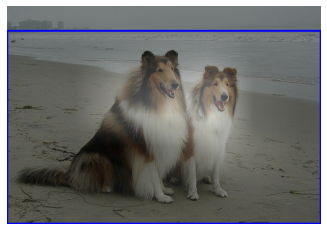

In [ ]:
item = get_one(ds_test)

grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
image = copy.deepcopy(item['image'])

origin_image = image.astype(np.uint8)
cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)

rect = get_bbox(grad_cam_image)
print(rect)

image = cv2.drawContours(blended_image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.axis("off")
plt.show()


바운딩 박스를 구할때 score thresh 변경.

[[ 95  83]
 [418  31]
 [464 316]
 [141 368]]


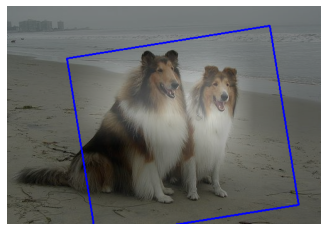

In [ ]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)

origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)

rect = get_bbox(grad_cam_image,0.1)
print(rect)
image = copy.deepcopy(item['image'])
image = cv2.drawContours(blended_image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.axis("off")
plt.show()

bounding 박스를 구할때 더욱 정교하게 구하거나, OpenCV를 더 파봐야 겠다.

# IoU 구하기

### 정답 바운딩 박스(ground truth) 와 예측값 바운딩 박스(prediction box) 두 가지를 이용해서 IoU를 계산하는 get_iou() 함수를 만들어 주세요.

In [ ]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다.
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]),  #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1])   #bounding box의 x_max
    ]
    return bbox

In [ ]:
# minmax를 rect으로 변경
def minmax_to_rect(minmax, image):

    rect = [
        [int(minmax[1]*float(image.shape[1])), int(minmax[0]*float(image.shape[0]))],
        [int(minmax[3]*float(image.shape[1])), int(minmax[0]*float(image.shape[0]))],
        [int(minmax[3]*float(image.shape[1])), int(minmax[2]*float(image.shape[0]))],
        [int(minmax[1]*float(image.shape[1])), int(minmax[2]*float(image.shape[0]))]
    ]
    return np.array(rect)

In [ ]:
pred_bbox = rect_to_minmax(rect, item['image'])

print(f"실제 이미지의 bounding box :  {item['objects']['bbox']}" )
print(f"grad_cam으로 얻은 bounding box : {pred_bbox}")


실제 이미지의 bounding box :  [[0.19596542 0.02       0.9048991  0.578     ]
 [0.26224783 0.584      0.89048994 0.736     ]]
grad_cam으로 얻은 bounding box : [0.0893371757925072, 0.19, 1.0605187319884726, 0.928]


In [ ]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])

    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [ ]:
def IOU_Performance_comp(item, model):

    cam_image = generate_cam(model, item)
    grad_cam_image = generate_grad_cam(model, 'conv5_block3_out', item)

    image = copy.deepcopy(item['image'])

    cam_rect = get_bbox(cam_image)
    image = cv2.drawContours(image, [cam_rect], 0, (255,0,0), 2)

    grad_rect = get_bbox(grad_cam_image)
    image = cv2.drawContours(image, [grad_rect], 0, (0,0,255), 2)

    bbox_label = minmax_to_rect(item['objects']['bbox'][0], image)
    image = cv2.drawContours(image, [bbox_label], 0, (0,255,0), 2)

    plt.imshow(image)
    plt.title("green:Ground truth, red:CAM, blue:Grad-CAM")
    plt.axis("off")
    plt.show()

    # IOU 결과
    pred_bbox1 = rect_to_minmax(cam_rect, item['image'])
    cam_iou = get_iou(pred_bbox1, item['objects']['bbox'][0])

    pred_bbox2 = rect_to_minmax(grad_rect, item['image'])
    grad_cam_iou = get_iou(pred_bbox2, item['objects']['bbox'][0])

    print("Red: CAM의 IOU",cam_iou)
    print("Blue: Grad-CAM의 IOU",grad_cam_iou)

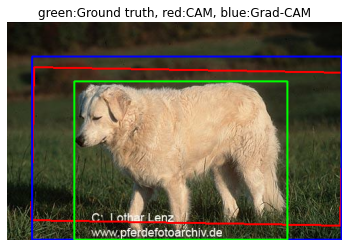

Red: CAM의 IOU 0.5845488157904446
Blue: Grad-CAM의 IOU 0.5925027722531229


In [ ]:
item = get_one(ds_test)
IOU_Performance_comp(item, cam_model)

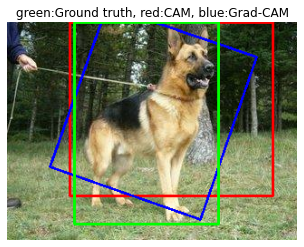

Red: CAM의 IOU 0.6400804228174102
Blue: Grad-CAM의 IOU 0.6384700203702026


In [ ]:
item = get_one(ds_test)
IOU_Performance_comp(item, cam_model)

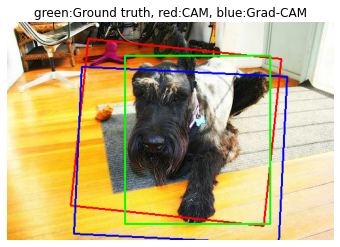

Red: CAM의 IOU 0.6195326754687814
Blue: Grad-CAM의 IOU 0.5821889193499441


In [ ]:
item = get_one(ds_test)
IOU_Performance_comp(item, cam_model)

# Rubric 1. CAM을 얻기 위한 기본모델의 구성과 학습이 정상 진행되었는가?
* ResNet50 + GAP + DenseLayer 결합된 CAM 모델의 학습과정이 안정적으로 수렴하였다.

![image](https://github.com/JeJuBOO/Aiffel_Nodes/assets/71332005/0085d801-9178-466c-986e-ab7a308a5333)
위 모델을
![image](https://github.com/JeJuBOO/Aiffel_Nodes/assets/71332005/9b7fac86-eb2b-4fcb-adcb-7936f5e61ee9)
epoch 10번 수행하였습니다.

# Rubric 2. 분류근거를 설명 가능한 Class activation map을 얻을 수 있는가?
* CAM 방식과 Grad-CAM 방식의 class activation map이 정상적으로 얻어지며, 시각화하였을 때 해당 object의 주요 특징 위치를 잘 반영한다.

* CAM   
![image](https://github.com/JeJuBOO/Aiffel_Nodes/assets/71332005/a9339e9a-eacc-4cb5-822c-81f1e6452f9e)

* Grad-CAM   
![image](https://github.com/JeJuBOO/Aiffel_Nodes/assets/71332005/f14f04fb-500b-4d4d-99f4-31c1577b0189)


# Rubric 3. 인식결과의 시각화 및 성능 분석을 적절히 수행하였는가?
* CAM과 Grad-CAM 각각에 대해 원본이미지합성, 바운딩박스, IoU 계산 과정을 통해 CAM과 Grad-CAM의 object localization 성능이 비교분석되었다.

![image](https://github.com/JeJuBOO/Aiffel_Nodes/assets/71332005/083d6dca-97d4-4cb6-a2ce-e43460fc2daf)